In [10]:
import numpy as np
from pathlib import Path

from gtda.homology import VietorisRipsPersistence
from gtda.plotting import plot_diagram
from gtda.diagrams import PersistenceEntropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from gtda.plotting import plot_point_cloud

# TDA magic
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA


from gtda.mapper.filter import Projection,Entropy,Eccentricity
from gtda.mapper.cover import CubicalCover
# scikit-learn method
# giotto-tda method
from gtda.mapper.cluster import FirstSimpleGap
import warnings
warnings.filterwarnings('ignore')
# Suppress the specific warning
warnings.filterwarnings("ignore", category=UserWarning, module='threadpoolctl')
import sys
import os
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'
os.environ['NUMEXPR_NUM_THREADS'] = '1'
# Redirect stderr to null to suppress the exception messages
sys.stderr = open(os.devnull, 'w')
import ctypes

# Suppress low-level warnings from C code
libc = ctypes.CDLL(None)
libc.prctl(15, 0, 0, 0, 0)

-1

In [11]:
def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    """Make point clouds for circles, spheres, and tori with random noise.
    """
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label circles with 0
    circle_labels = np.zeros(n_samples_per_shape)

    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label spheres with 1
    sphere_labels = np.ones(n_samples_per_shape)

    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    # label tori with 2
    torus_labels = 2 * np.ones(n_samples_per_shape)

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels))

    return point_clouds, labels


def make_gravitational_waves(
    path_to_data: Path,
    n_signals: int = 30,
    downsample_factor: int = 2,
    r_min: float = 0.075,
    r_max: float = 0.65,
    n_snr_values: int = 10,
        ):
    def padrand(V, n, kr):
        cut = np.random.randint(n)
        rand1 = np.random.randn(cut)
        rand2 = np.random.randn(n - cut)
        out = np.concatenate((rand1 * kr, V, rand2 * kr))
        return out

    Rcoef = np.linspace(r_min, r_max, n_snr_values)
    Npad = 500  # number of padding points on either side of the vector
    gw = np.load(path_to_data / "gravitational_wave_signals.npy")
    Norig = len(gw["data"][0])
    Ndat = len(gw["signal_present"])
    N = int(Norig / downsample_factor)

    ncoeff = []
    Rcoeflist = []

    for j in range(n_signals):
        ncoeff.append(10 ** (-19) * (1 / Rcoef[j % n_snr_values]))
        Rcoeflist.append(Rcoef[j % n_snr_values])

    noisy_signals = []
    gw_signals = []
    k = 0
    labels = np.zeros(n_signals)

    for j in range(n_signals):
        signal = gw["data"][j % Ndat][range(0, Norig, downsample_factor)]
        sigp = int((np.random.randn() < 0))
        noise = ncoeff[j] * np.random.randn(N)
        labels[j] = sigp
        if sigp == 1:
            rawsig = padrand(signal + noise, Npad, ncoeff[j])
            if k == 0:
                k = 1
        else:
            rawsig = padrand(noise, Npad, ncoeff[j])
        noisy_signals.append(rawsig.copy())
        gw_signals.append(signal)

    return noisy_signals, gw_signals, labels

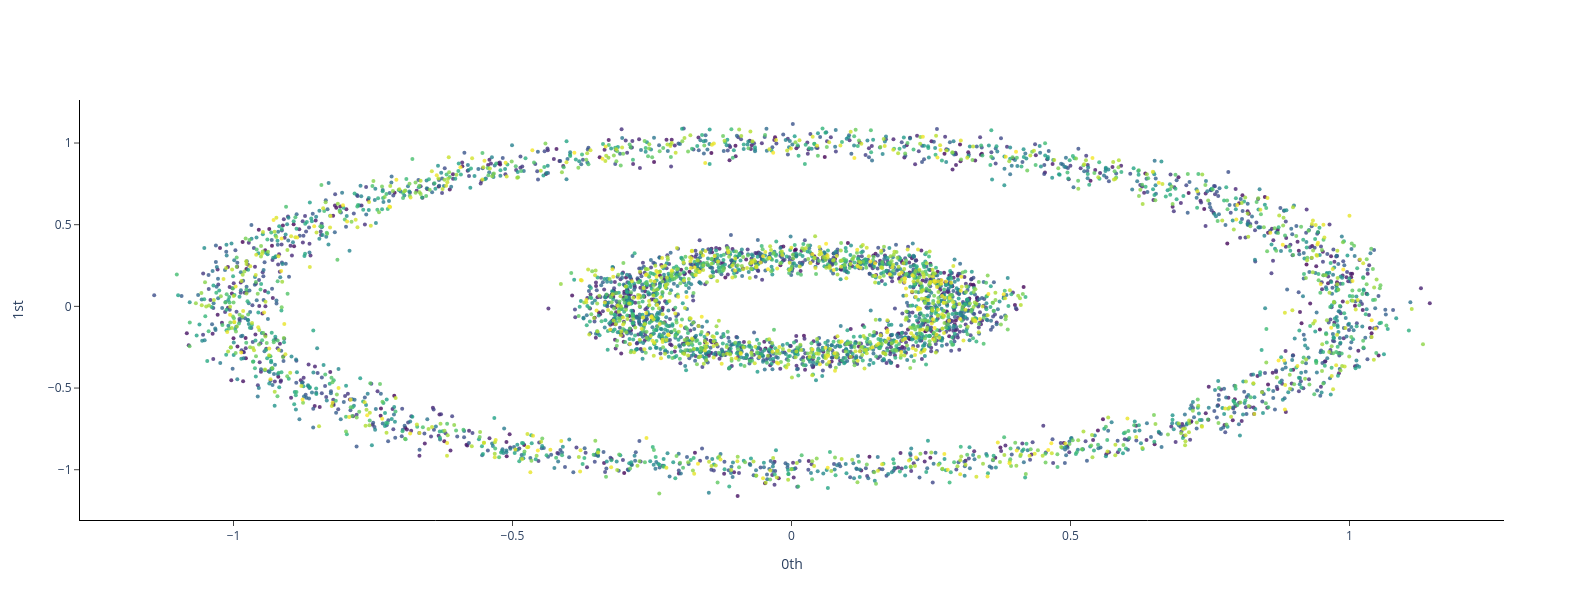

In [37]:
data, _ = datasets.make_circles(n_samples=5000, noise=0.05, factor=0.3, random_state=42)

plot_point_cloud(data)

In [38]:
n_samples_per_class = 10
point_clouds, labels = make_point_clouds(n_samples_per_class, 10, 0.1)
point_clouds.shape
print(f"There are {point_clouds.shape[0]} point clouds in {point_clouds.shape[2]} dimensions, "
      f"each with {point_clouds.shape[1]} points.")

There are 30 point clouds in 3 dimensions, each with 100 points.


In [39]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1, 2])  # Parameter explained in the text
diagrams = VR.fit_transform(point_clouds)
diagrams.shape

(30, 169, 3)

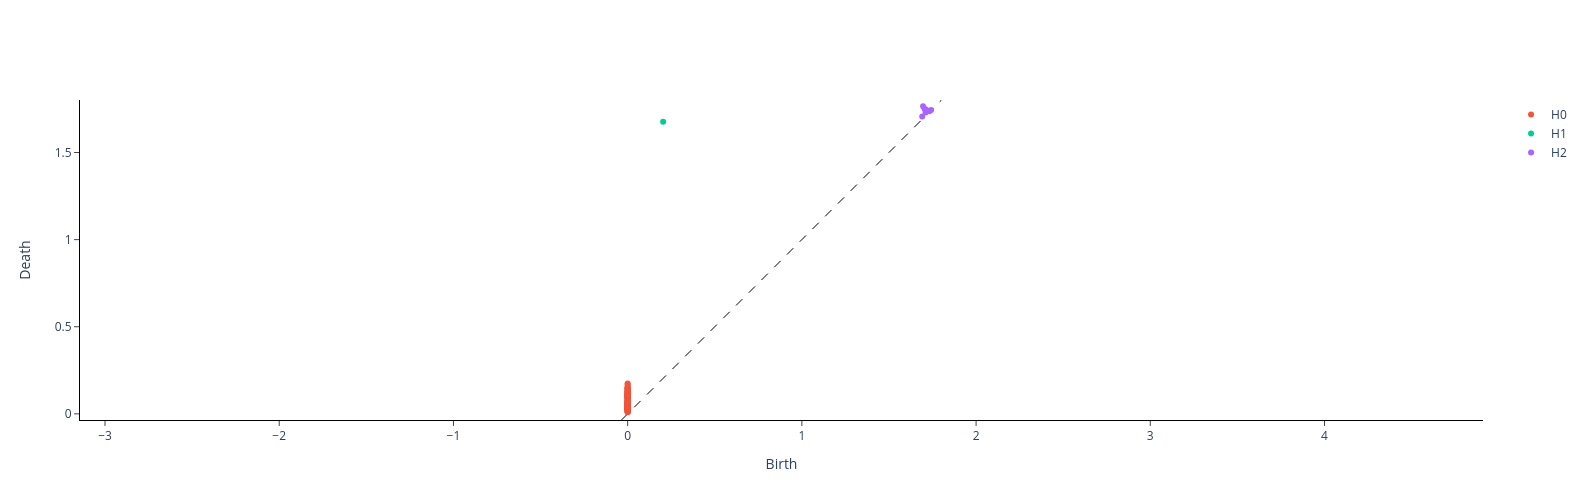

In [40]:
i = 0
plot_diagram(diagrams[i])

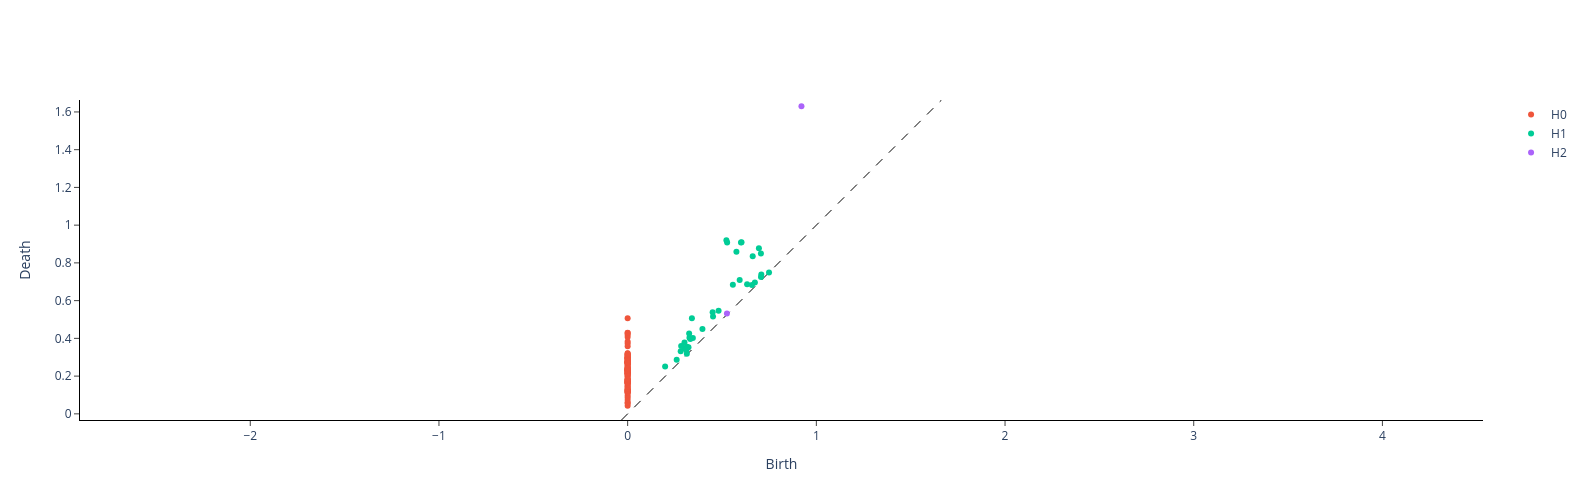

In [41]:
i = 11
plot_diagram(diagrams[i])

In [42]:
PE = PersistenceEntropy()
features = PE.fit_transform(diagrams)

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(features, labels)
model = RandomForestClassifier()
model.fit(X_train, y_train)
model.score(X_valid, y_valid)

1.0

In [44]:
from sklearn.pipeline import make_pipeline

steps = [VietorisRipsPersistence(homology_dimensions=[0, 1, 2]),
         PersistenceEntropy(),
         RandomForestClassifier()]
pipeline = make_pipeline(*steps)

pcs_train, pcs_valid, labels_train, labels_valid = train_test_split(point_clouds, labels)

pipeline.fit(pcs_train, labels_train)

pipeline.score(pcs_valid, labels_valid)

1.0

In [45]:
import numpy as np
np.random.seed(seed=42)
from gtda.homology import VietorisRipsPersistence
from sklearn.datasets import make_circles

X = np.asarray([
    make_circles(100, factor=np.random.random())[0]
    for i in range(10)
])

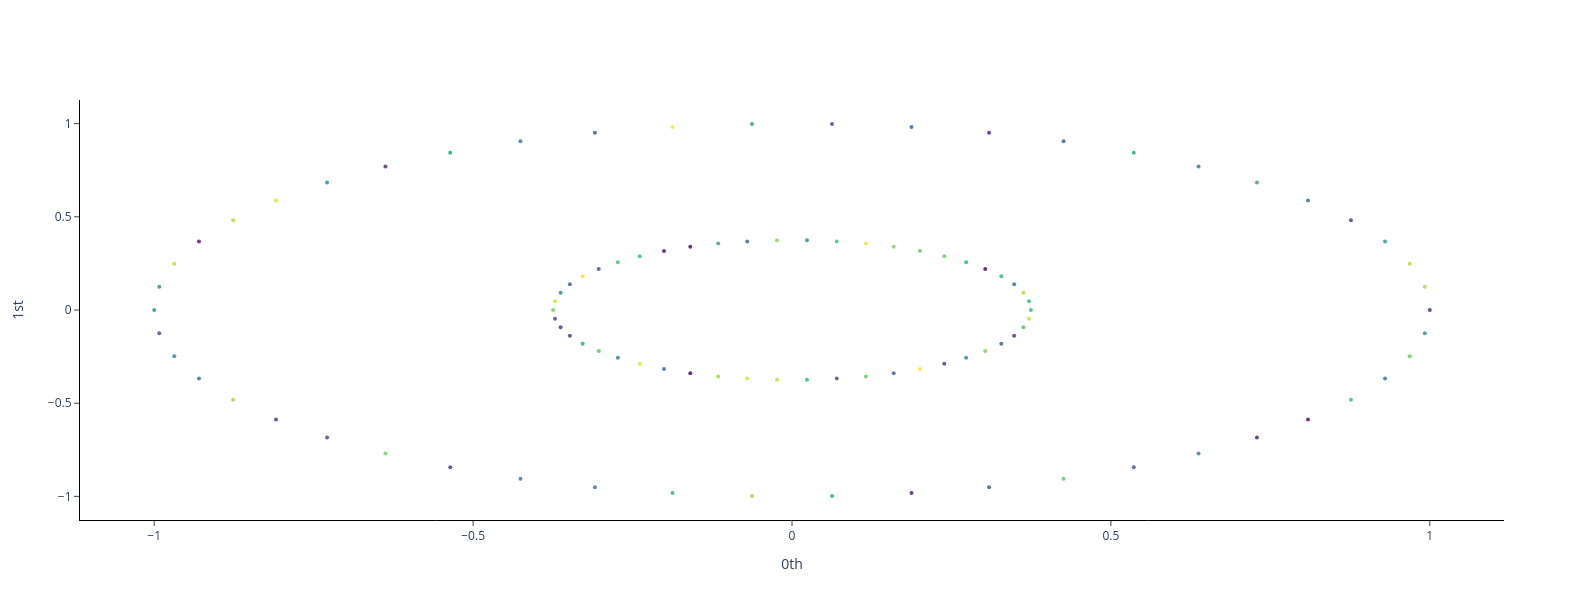

In [46]:
from gtda.plotting import plot_point_cloud
i = 0
plot_point_cloud(X[i])

In [47]:
VR = VietorisRipsPersistence()
Xt = VR.fit_transform(X)

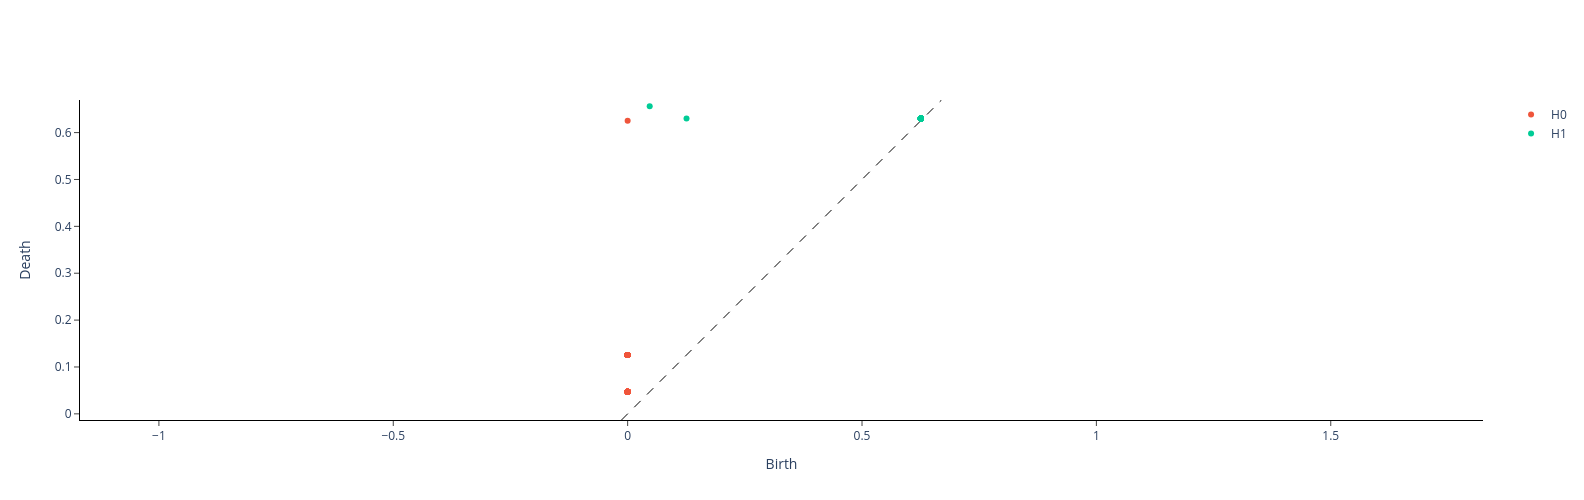

In [48]:
VR.plot(Xt, sample=i)

In [49]:
# Define filter function – can be any scikit-learn transformer
filter_func = Projection(columns=[0, 1])
# Define cover
cover = CubicalCover(n_intervals=50, overlap_frac=0.1)
# Choose clustering algorithm – default is DBSCAN
clusterer = DBSCAN()

# Configure parallelism of clustering step
n_jobs = 8

# Initialise pipeline
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
   n_jobs=n_jobs)

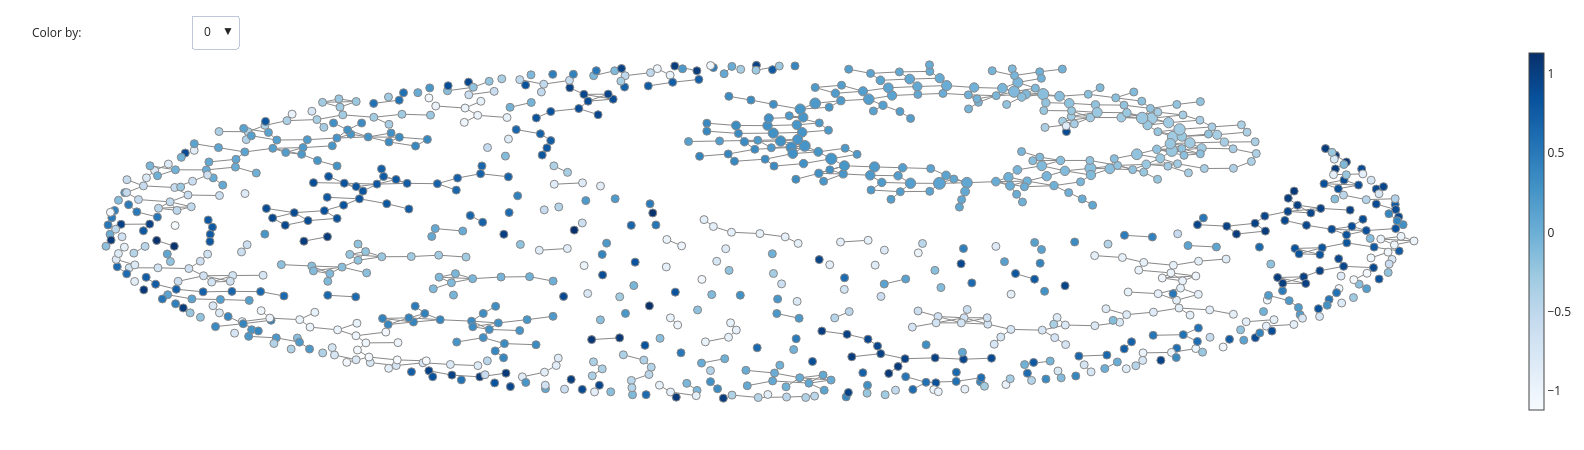

In [50]:
plotly_params = {"node_trace": {"marker_colorscale": "Blues"}}
fig = plot_static_mapper_graph(
    pipe, data, color_data=data, plotly_params=plotly_params
)
fig.show(config={'scrollZoom': True})

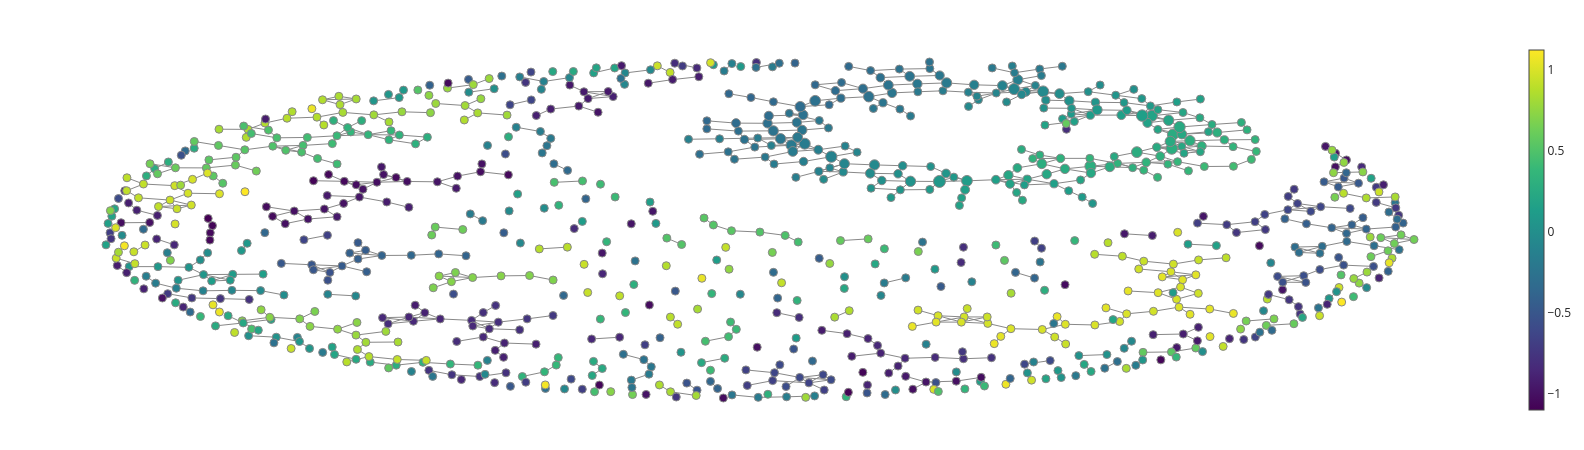

In [51]:
# Initialise estimator to color graph by
pca = PCA(n_components=1)

fig = plot_static_mapper_graph(
    pipe, data, color_data=data, color_features=pca
)
fig.show(config={'scrollZoom': True})

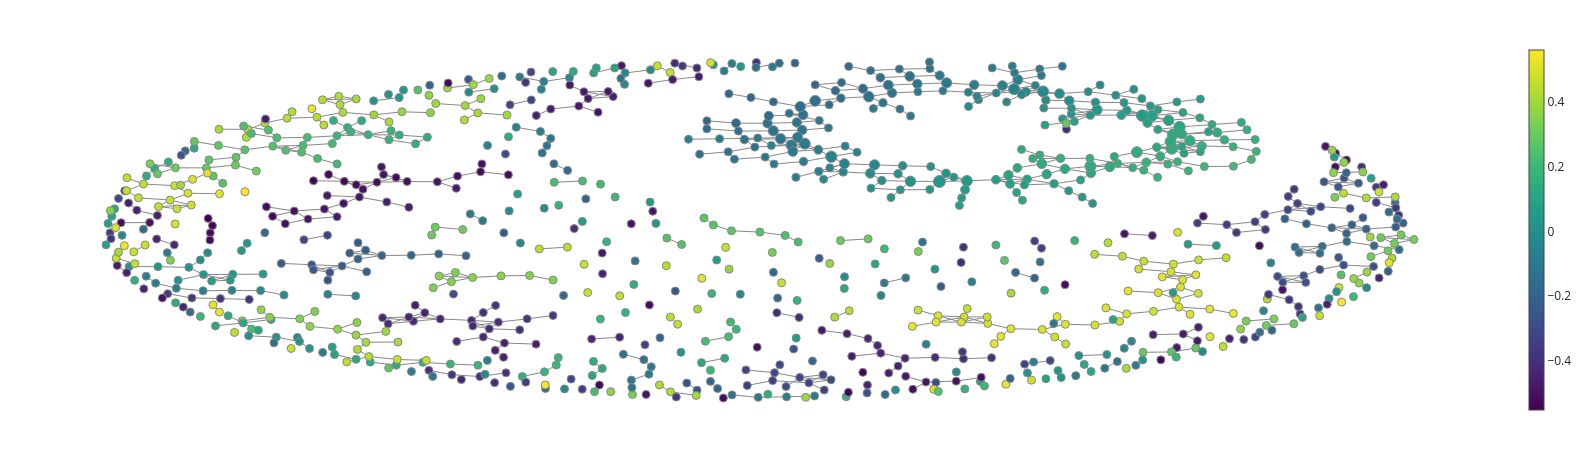

In [52]:
fig = plot_static_mapper_graph(
    pipe, data, color_data=data, color_features=pca, node_color_statistic=lambda x: np.mean(x) / 2
)
fig.show(config={'scrollZoom': True})

In [53]:
graph = pipe.fit_transform(data)
node_elements = graph.vs["node_elements"]
print(f"There are {len(node_elements)} nodes.\nThe first node consists of row indices {node_elements[0]}.")

There are 938 nodes.
The first node consists of row indices [   0 4506].


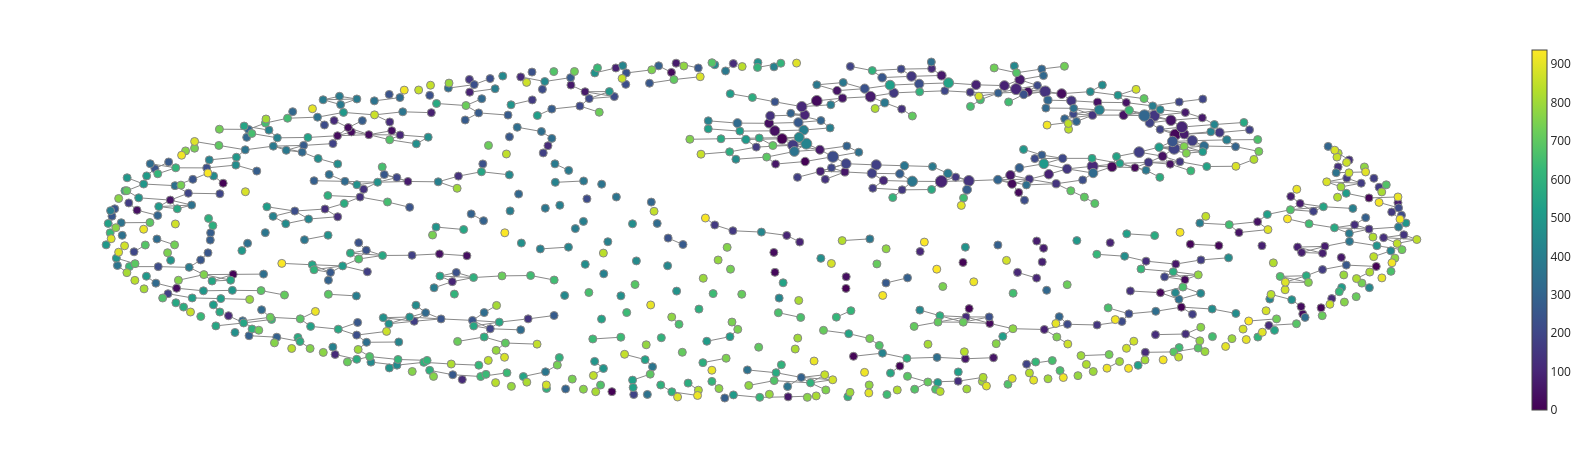

In [54]:
fig = plot_static_mapper_graph(
    pipe, data, node_color_statistic=np.arange(len(node_elements))
)
fig.show(config={'scrollZoom': True})

In [55]:
pipe.set_params(filter_func=Entropy())

MapperPipeline(steps=[('pullback_cover',
                       ListFeatureUnion(transformer_list=[('clustering_preprocessing',
                                                           FunctionTransformer(validate=True)),
                                                          ('map_and_cover',
                                                           Pipeline(steps=[('scaler',
                                                                            FunctionTransformer()),
                                                                           ('filter_func',
                                                                            Entropy()),
                                                                           ('cover',
                                                                            CubicalCover(n_intervals=50))]))])),
                      ('clustering',
                       ParallelClustering(clusterer=DBSCAN(), n_jobs=8)),
                      ('nerve', Nerve())])